<a href="https://colab.research.google.com/github/arezoo17/movie-box-office-prediction/blob/main/1_EDA_Data_Prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Feature Dictionary (Newly Created Columns)
#### This section describes the new columns extracted from the Date and Time features.
#### - `Datetime`: Combined Date and Time column in proper datetime format.
#### - `Hour`: Hour of the transaction (0-23).
#### - `DayOfWeek`: Day of the week when the transaction occurred (0=Monday, 6=Sunday).
#### - `Month`: The month in which the transaction took place (1-12).
#### - `DayOfMonth`: The specific day of the month when the transaction occurred (1-31).
#### - `IsWeekend`: A binary flag indicating if the transaction happened on a weekend:
####     - `0` = No (Transaction on a weekday: Monday-Friday)
####     - `1` = Yes (Transaction on a weekend: Saturday-Sunday)
### Payment Currency Encoding:
####Albanian lek → 0
####Dirham → 1
####Euro → 2
####Indian rupee → 3
####Mexican Peso → 4
####Moroccan dirham → 5
####Naira → 6
####Pakistani rupee → 7
####Swiss franc → 8
####Turkish lira → 9
####UK pounds → 10
####US dollar → 11
####Yen → 12

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp, mannwhitneyu, shapiro
import scipy.stats as stats
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler


#1.Load and Inspect Data

In [4]:
file_path = "/content/drive/My Drive/SAML-D.csv"
df = pd.read_csv(file_path)
df.head()

,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type
0,10:35:19,2022-10-07,8724731955,2769355426,1459.15,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits
1,10:35:20,2022-10-07,1491989064,8401255335,6019.64,UK pounds,Dirham,UK,UAE,Cross-border,0,Normal_Fan_Out
2,10:35:20,2022-10-07,287305149,4404767002,14328.44,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Small_Fan_Out
3,10:35:21,2022-10-07,5376652437,9600420220,11895.00,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In
4,10:35:21,2022-10-07,9614186178,3803336972,115.25,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits


# 2.Data Cleaning

## 2.1 Dealing with Missing Values

In [5]:
df.isnull().sum().sort_values(ascending=False)


,0
Time,0
Date,0
Sender_account,0
Receiver_account,0
Amount,0
Payment_currency,0
Received_currency,0
Sender_bank_location,0
Receiver_bank_location,0
Payment_type,0


## 2.2 Removing Duplicates

In [6]:
initial_count = df.shape[0]
df.drop_duplicates(inplace=True)
print("Dropped duplicates: ", initial_count - df.shape[0])


Dropped duplicates:  0


In [7]:
df["Is_laundering"].value_counts()

,count
Is_laundering,
0,9494979
1,9873


### According to the result of this part, we can see that the data is imbalanced because the normal transactions are near to 10 million, while laundering transactions are approximately 10000.
------

## 2.3 Data Type Corrections

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9504852 entries, 0 to 9504851
Data columns (total 12 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Time                    object 
 1   Date                    object 
 2   Sender_account          int64  
 3   Receiver_account        int64  
 4   Amount                  float64
 5   Payment_currency        object 
 6   Received_currency       object 
 7   Sender_bank_location    object 
 8   Receiver_bank_location  object 
 9   Payment_type            object 
 10  Is_laundering           int64  
 11  Laundering_type         object 
dtypes: float64(1), int64(3), object(8)
memory usage: 870.2+ MB


### In this step, we convert the `Sender_account` and `Receiver_account` columns to string type. Since they represent identifiers rather than numerical values, converting them to strings prevents misleading numerical analysis.

In [9]:
# Convert account columns to string type
df['Sender_account'] = df['Sender_account'].astype(str)
df['Receiver_account'] = df['Receiver_account'].astype(str)

In [10]:
# Verify the conversion by checking data types
print(df.dtypes[['Sender_account', 'Receiver_account']])

Sender_account      object
Receiver_account    object
dtype: object


In [11]:
df.describe()

,Amount,Is_laundering
count,9.504852e+06,9.504852e+06
mean,8.762968e+03,1.038733e-03
std,2.561495e+04,3.221263e-02
min,3.730000e+00,0.000000e+00
25%,2.143688e+03,0.000000e+00
50%,6.113720e+03,0.000000e+00
75%,1.045846e+04,0.000000e+00
max,1.261850e+07,1.000000e+00


In [12]:
# Convert account columns to integer type for the feature usage
df['Sender_account'] = df['Sender_account'].astype(int)
df['Receiver_account'] = df['Receiver_account'].astype(int)

# 3. Exploratory Data Analysis (EDA)

## 3.1 Univariate Analysis
**Goal:** Understand individual feature distributions.

### Visualizing the "Time" Column

We begin by examining the **Time** column, which follows the format `HH:MM:SS`. By visualizing the distribution of transactions across different hours of the day, we can identify peak transaction hours and patterns. This analysis will help us understand transaction behaviors and potentially spot time-based anomalies.

### Visualizing the Distribution of Transactions by Hour for All Transactions (`df`)

We will visualize the distribution of transactions by hour in the full dataset (`df`). This will help us understand the general pattern of transaction activity throughout the day and spot any trends or periods of peak transaction activity.

### Visualizing the Distribution of Transactions by Hour for Fraudulent Transactions (`df_Laundering`)

Next, we will examine the distribution of transactions by hour specifically for the **fraudulent transactions** in the `df_Laundering` dataset. This analysis will help us identify any unusual patterns or specific time windows when fraudulent transactions are more likely to occur.

We will:
- Extract the hour from the **Time** column in both `df` and `df_Laundering`.
- Plot histograms to show the distribution of transactions for both datasets over different hours of the day. By comparing these visualizations, we can identify any anomalies or patterns specific to fraudulent transactions.

The next step will involve creating features based on the insights gained from these visualizations.



In [13]:
# Create a data frame with only fraudulent transactions to compare them with all the transactions
df_Laundering = df[df['Is_laundering'] == 1]
df_Laundering

,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type
317,10:46:37,2022-10-07,7401327478,4336451277,2603.300000,UK pounds,UK pounds,UK,UK,Cash Deposit,1,Smurfing
1206,11:19:32,2022-10-07,6340007440,4316483340,106.040000,UK pounds,Indian rupee,UK,India,Cash Withdrawal,1,Cash_Withdrawal
1649,11:35:42,2022-10-07,3758118046,6081504025,5903.330000,UK pounds,Mexican Peso,UK,Mexico,Cross-border,1,Behavioural_Change_2
1954,11:45:53,2022-10-07,445154846,4497771501,3957.870000,UK pounds,Naira,UK,Nigeria,Cross-border,1,Structuring
3304,12:39:03,2022-10-07,2758469152,2987279234,7832.410000,UK pounds,UK pounds,UK,UK,Debit card,1,Structuring
...,...,...,...,...,...,...,...,...,...,...,...,...
9499725,07:56:34,2023-08-23,6347914836,8661825378,6702.170000,UK pounds,US dollar,UK,USA,Cross-border,1,Layered_Fan_In
9501820,09:12:18,2023-08-23,9285879778,7750754,814.490000,UK pounds,Euro,UK,Austria,Cross-border,1,Behavioural_Change_1
9501946,09:16:07,2023-08-23,351184098,4257557167,7888.580000,UK pounds,Turkish lira,UK,Turkey,Cross-border,1,Behavioural_Change_2
9503705,10:18:07,2023-08-23,7929569569,8236488006,30061.133364,UK pounds,UK pounds,UK,UK,Credit card,1,Cycle


### Comparing the Distribution of Transactions by Hour for Non-Fraudulent and Fraudulent Transactions

We compared the distribution of transactions by hour of the day for the **full dataset (`df`)** and **fraudulent transactions (`df_Laundering`)**.

#### Insights from the Visualizations:
1. **Non-fraudulent transactions (`df`)**:
   - The distribution is relatively **uniform**, with a **peak around 7 AM**. This suggests no specific time concentration, except for the early peak.

2. **Fraudulent transactions (`df_Laundering`)**:
   - **Fraudulent transactions show a significant peak around 7 AM**, indicating a potential anomaly tied to this hour. After the peak, the distribution becomes more even throughout the day.

In [14]:
# Convert to datetime format
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Extract features from Datetime
df['Hour'] = df['Datetime'].dt.hour  # Hour of transaction
df['DayOfWeek'] = df['Datetime'].dt.dayofweek  # Monday = 0, Sunday = 6
df['Month'] = df['Datetime'].dt.month  # Month of transaction
df['DayOfMonth'] = df['Datetime'].dt.day  # Day of the month (1-31)
df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)  # 1 if Sat/Sun, else 0

# Split dataset into normal and laundering transactions
df_normal = df[df['Is_laundering'] == 0]
df_laundering = df[df['Is_laundering'] == 1]

# Debugging: Check extracted features
print("Sample of extracted time features:")
print(df[['Hour', 'DayOfWeek', 'Month', 'DayOfMonth', 'IsWeekend']].head())


Sample of extracted time features:
   Hour  DayOfWeek  Month  DayOfMonth  IsWeekend
0    10          4     10           7          0
1    10          4     10           7          0
2    10          4     10           7          0
3    10          4     10           7          0
4    10          4     10           7          0


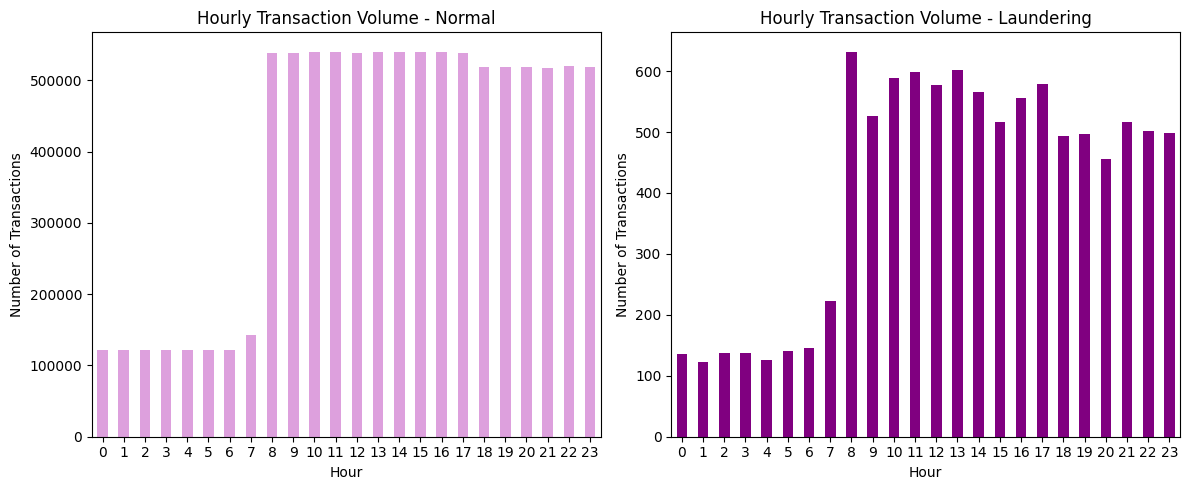

In [15]:
# Plot transactions per day - Separate for normal vs laundering transactions
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)  # First subplot
df_normal.groupby('Hour').size().plot(kind='bar', color='plum')
plt.title('Hourly Transaction Volume - Normal')
plt.xlabel('Hour')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=0)

plt.subplot(1,2,2)  # Second subplot
df_laundering.groupby('Hour').size().plot(kind='bar', color='purple')
plt.title('Hourly Transaction Volume - Laundering')
plt.xlabel('Hour')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()


### Laundering transactions peak during regular business hours, similar to normal transactions, but show a more gradual increase starting earlier in the day, suggesting potential strategic timing to blend with legitimate activity.
----

### The distribution of transactions across different days of week


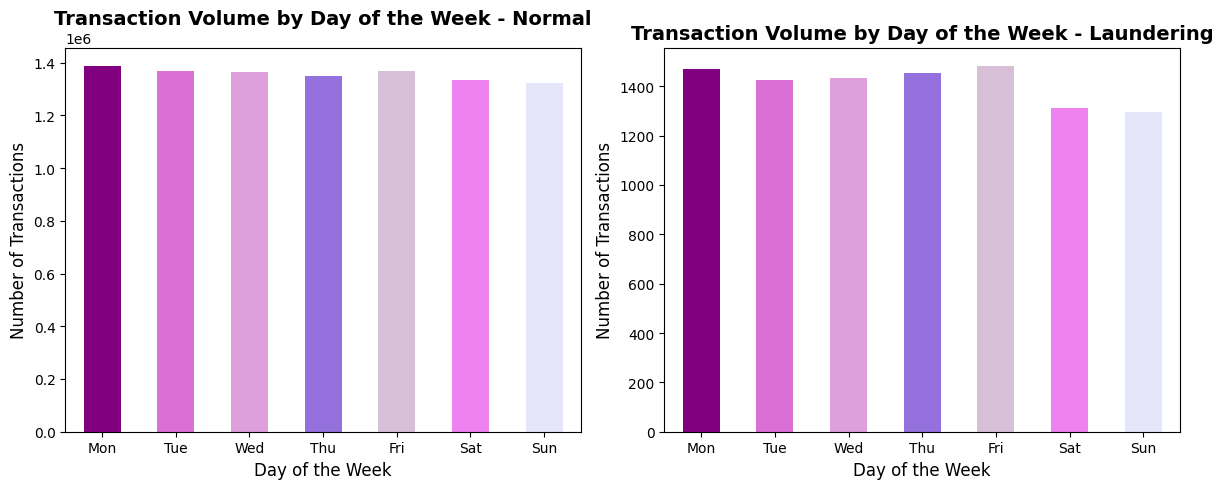

In [16]:
# Define purple shades for each day
day_colors = ['purple', 'orchid', 'plum', 'mediumpurple', 'thistle', 'violet', 'lavender']

# Define a mapping for day labels
day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Group transactions by day of the week
day_normal = df_normal.groupby('DayOfWeek').size().reindex(range(7))
day_laundering = df_laundering.groupby('DayOfWeek').size().reindex(range(7))

# Create figure for side-by-side comparison
plt.figure(figsize=(12, 5))

# First subplot: Normal Transactions by Day of the Week
plt.subplot(1, 2, 1)
day_normal.plot(kind='bar', color=day_colors)
plt.title('Transaction Volume by Day of the Week - Normal', fontsize=14, fontweight='bold')
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xticks(ticks=range(7), labels=day_labels, rotation=0)

# Second subplot: Laundering Transactions by Day of the Week
plt.subplot(1, 2, 2)
day_laundering.plot(kind='bar', color=day_colors)
plt.title('Transaction Volume by Day of the Week - Laundering', fontsize=14, fontweight='bold')
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xticks(ticks=range(7), labels=day_labels, rotation=0)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


### Laundering transactions occur consistently throughout the week, mirroring normal transaction trends, but with a slight decrease on weekends, which may indicate reduced financial activity or increased monitoring during non-business days.
---

### Visualize the total number of transactions per different period

In [17]:
# Categorize into Beginning (1-10), Middle (11-20), End (21-31)
df_laundering['MonthPeriod'] = np.where(df_laundering['DayOfMonth'] <= 10, 'Beginning',
                           np.where(df_laundering['DayOfMonth'] <= 20, 'Middle', 'End'))

# Count number of transactions per period
summary_stats = df_laundering['MonthPeriod'].value_counts()
print("Laundering Transactions per Period:\n", summary_stats)

Laundering Transactions per Period:
 MonthPeriod
Middle       4248
Beginning    3145
End          2480
Name: count, dtype: int64


<ipython-input-17-3941b90f06b3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_laundering['MonthPeriod'] = np.where(df_laundering['DayOfMonth'] <= 10, 'Beginning',


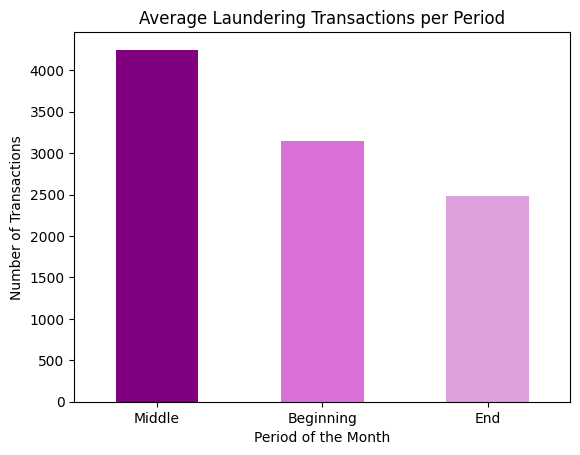

In [18]:
summary_stats.plot(kind='bar', color=['Purple', 'Orchid', 'plum'])
plt.title("Average Laundering Transactions per Period")
plt.xlabel("Period of the Month")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=0)
plt.show()

### Most of the laundering transaction happened in the middle of the month

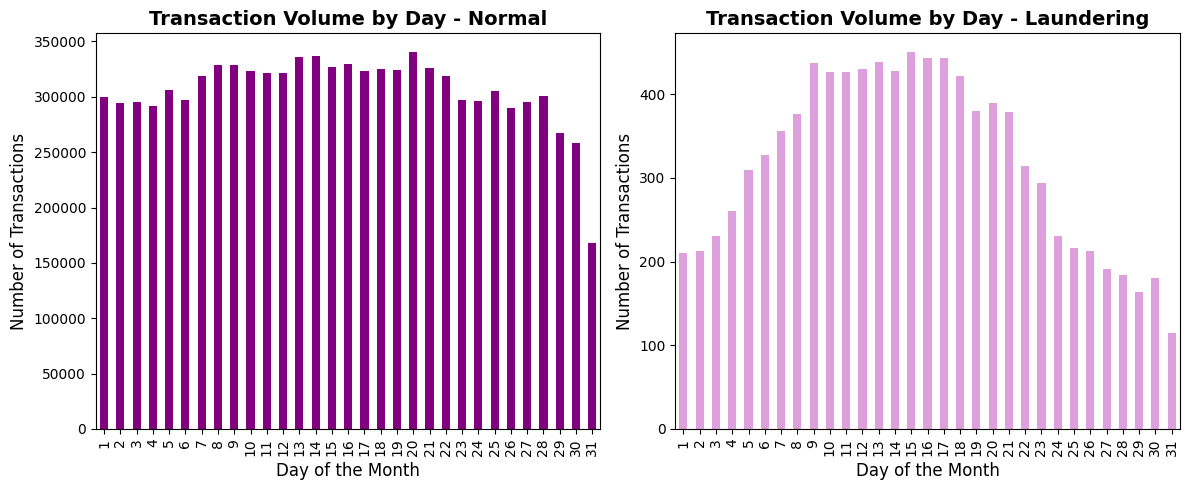

In [19]:
# Create figure for side-by-side comparison
plt.figure(figsize=(12, 5))

# First subplot: Normal Transactions
plt.subplot(1, 2, 1)
df_normal.groupby('DayOfMonth').size().plot(kind='bar', color='Purple')
plt.title('Transaction Volume by Day - Normal', fontsize=14, fontweight='bold')
plt.xlabel('Day of the Month', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xticks(rotation=90)

# Second subplot: Laundering Transactions
plt.subplot(1, 2, 2)
df_laundering.groupby('DayOfMonth').size().plot(kind='bar', color='Plum')
plt.title('Transaction Volume by Day - Laundering', fontsize=14, fontweight='bold')
plt.xlabel('Day of the Month', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xticks(rotation=90)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


### We can see that most of the fraudulent transactions happen between the 10th to 20th of the month.
----

## Visualize the weekday and weekend distribution

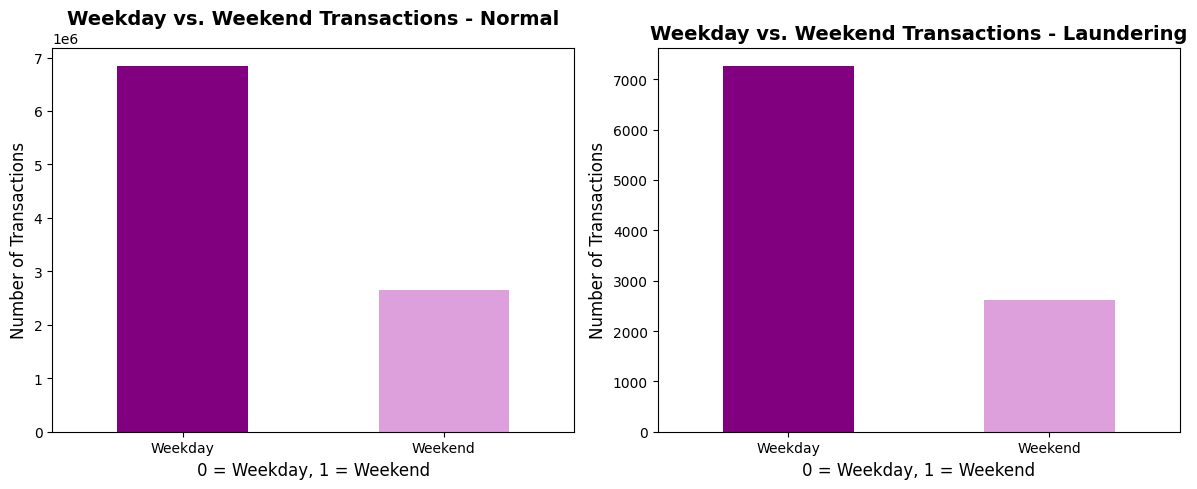

In [20]:
# Count transactions for Weekday (0) and Weekend (1)
weekend_counts = df['IsWeekend'].value_counts()
laundering_weekend_counts = df_laundering['IsWeekend'].value_counts()

# Create figure for side-by-side comparison
plt.figure(figsize=(12, 5))

# First subplot: Normal Transactions (df)
plt.subplot(1, 2, 1)
weekend_counts.plot(kind='bar', color=['Purple', 'Plum'])
plt.title('Weekday vs. Weekend Transactions - Normal', fontsize=14, fontweight='bold')
plt.xlabel('0 = Weekday, 1 = Weekend', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Weekday', 'Weekend'], rotation=0)

# Second subplot: Laundering Transactions (df_laundering)
plt.subplot(1, 2, 2)
laundering_weekend_counts.plot(kind='bar', color=['Purple', 'Plum'])
plt.title('Weekday vs. Weekend Transactions - Laundering', fontsize=14, fontweight='bold')
plt.xlabel('0 = Weekday, 1 = Weekend', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Weekday', 'Weekend'], rotation=0)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


### More transactions occur on weekdays than weekends (both for normal and laundering transactions).
---

## Visualize the monthly distribution

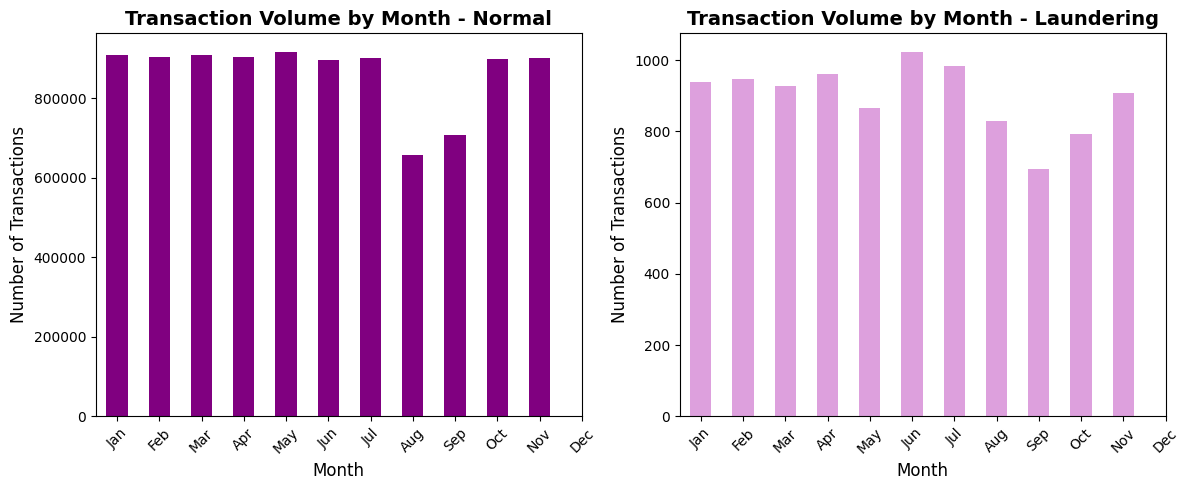

In [21]:
# Define colors
normal_color = 'Purple'  # Color for normal transactions
laundering_color = 'Plum'  # Color for laundering transactions

# Ensure months are sorted correctly
normal_transactions = df_normal.groupby('Month').size().sort_index()
laundering_transactions = df_laundering.groupby('Month').size().sort_index()

# Define month labels
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Create figure for side-by-side comparison
plt.figure(figsize=(12, 5))

# First subplot: Normal Transactions
plt.subplot(1, 2, 1)
normal_transactions.plot(kind='bar', color=normal_color)
plt.title('Transaction Volume by Month - Normal', fontsize=14, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xticks(ticks=range(12), labels=month_labels, rotation=45)  # Ensure correct order

# Second subplot: Laundering Transactions
plt.subplot(1, 2, 2)
laundering_transactions.plot(kind='bar', color=laundering_color)
plt.title('Transaction Volume by Month - Laundering', fontsize=14, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xticks(ticks=range(12), labels=month_labels, rotation=45)  # Ensure correct order

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


### Laundering transactions generally follow the same monthly pattern as normal transactions, with slight variations, particularly a dip in September, which may indicate lower financial activity during this period.
---

<ipython-input-22-2adfeeceeb83>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_normal['Season'] = df_normal['Month'].map(season_mapping)
<ipython-input-22-2adfeeceeb83>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_laundering['Season'] = df_laundering['Month'].map(season_mapping)


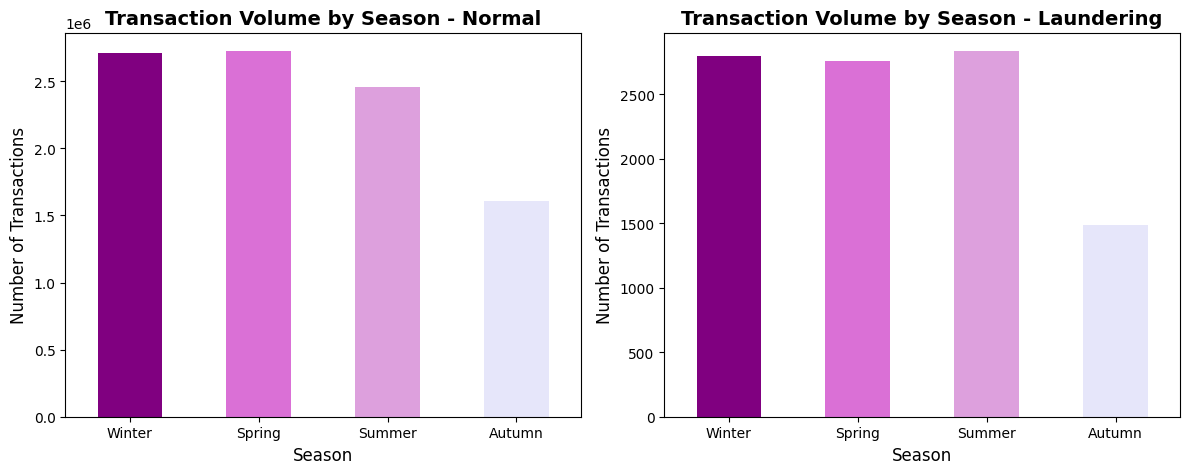

In [22]:
# Define purple shades for each season
season_colors = ['purple', 'orchid', 'plum', 'lavender']  # Winter, Spring, Summer, Autumn

# Define a mapping from Month to Season
season_mapping = {
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
}

# Create new column 'Season'
df_normal['Season'] = df_normal['Month'].map(season_mapping)
df_laundering['Season'] = df_laundering['Month'].map(season_mapping)

# Group by season
seasonal_normal = df_normal.groupby('Season').size().reindex(['Winter', 'Spring', 'Summer', 'Autumn'])
seasonal_laundering = df_laundering.groupby('Season').size().reindex(['Winter', 'Spring', 'Summer', 'Autumn'])

# Create figure for side-by-side comparison
plt.figure(figsize=(12, 5))

# First subplot: Normal Transactions by Season
plt.subplot(1, 2, 1)
seasonal_normal.plot(kind='bar', color=season_colors)
plt.title('Transaction Volume by Season - Normal', fontsize=14, fontweight='bold')
plt.xlabel('Season', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xticks(rotation=0)

# Second subplot: Laundering Transactions by Season
plt.subplot(1, 2, 2)
seasonal_laundering.plot(kind='bar', color=season_colors)
plt.title('Transaction Volume by Season - Laundering', fontsize=14, fontweight='bold')
plt.xlabel('Season', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xticks(rotation=0)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


### Laundering transactions follow a similar seasonal pattern to normal transactions, peaking in Winter, Spring, and Summer, with a noticeable drop in Autumn, possibly reflecting overall financial activity trends.
----

# Amount

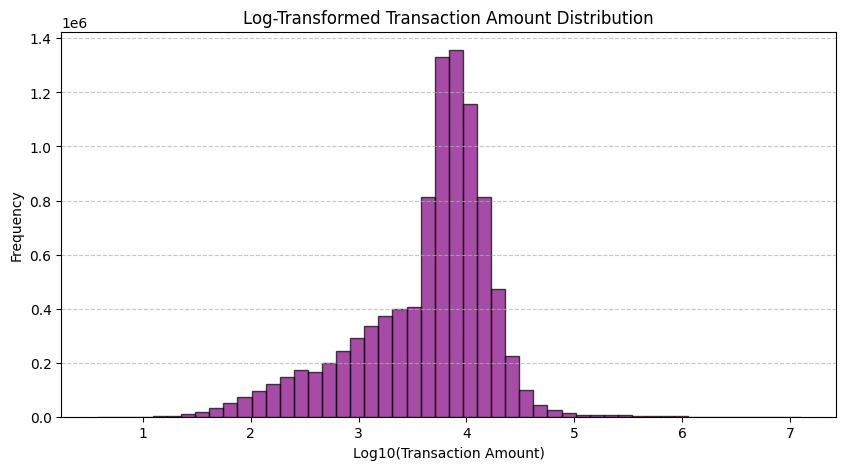

In [23]:
# Remove zero values to avoid log(0) errors
df_nonzero = df[df['Amount'] > 0]

# Apply log transformation
log_amounts = np.log10(df_nonzero['Amount'])

# Plot the histogram
plt.figure(figsize=(10, 5))
plt.hist(log_amounts, bins=50, color='Purple', edgecolor='black', alpha=0.7)

# Add titles and labels
plt.title('Log-Transformed Transaction Amount Distribution')
plt.xlabel('Log10(Transaction Amount)')
plt.ylabel('Frequency')

# Show grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()

-------

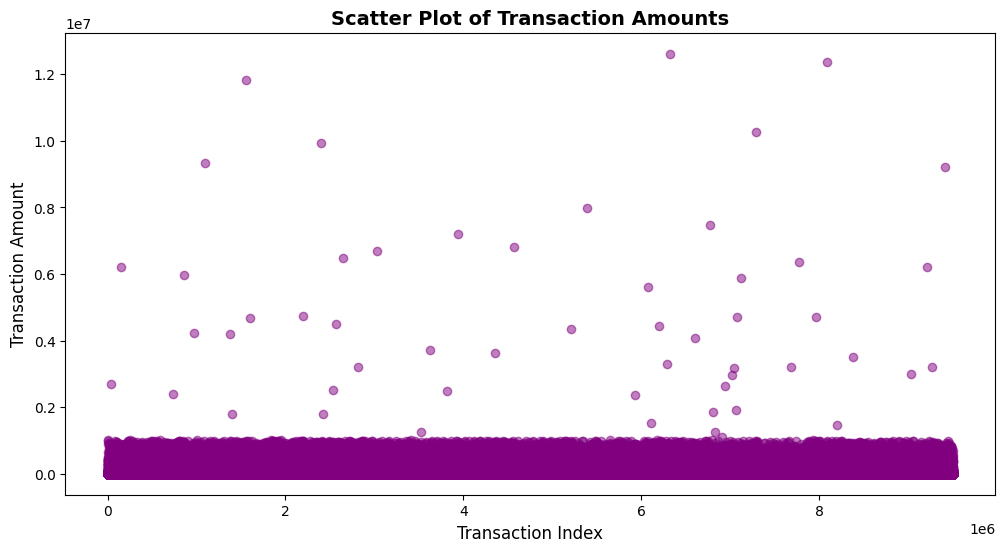

In [24]:
import matplotlib.pyplot as plt

# Create scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(df.index, df['Amount'], color='purple', alpha=0.5)

# Labels and title
plt.title('Scatter Plot of Transaction Amounts', fontsize=14, fontweight='bold')
plt.xlabel('Transaction Index', fontsize=12)
plt.ylabel('Transaction Amount', fontsize=12)

# Show plot
plt.show()


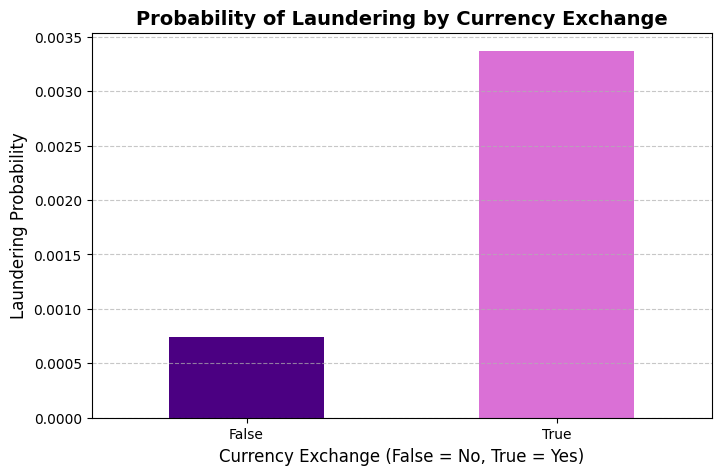

In [25]:
# Ensure Is_laundering is numeric (convert if necessary)
df['Is_laundering'] = df['Is_laundering'].astype(int)

# Create a new column to flag currency exchange transactions
df['Currency_Exchange'] = df['Payment_currency'] != df['Received_currency']

# Compute the number of laundering vs. normal transactions for each category
laundering_by_exchange = df.groupby('Currency_Exchange')['Is_laundering'].value_counts(normalize=True).unstack()


# Visualize laundering probability by currency exchange status
plt.figure(figsize=(8,5))

# Ensure the correct column is selected (use .get() to avoid KeyError)
if 1 in laundering_by_exchange.columns:
    laundering_by_exchange[1].plot(kind='bar', color=['indigo', 'orchid'])  # Updated colors
else:
    print("Warning: No laundering transactions found (1 is missing).")

plt.title("Probability of Laundering by Currency Exchange", fontsize=14, fontweight='bold')
plt.xlabel("Currency Exchange (False = No, True = Yes)", fontsize=12)
plt.ylabel("Laundering Probability", fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

#drop the Currency Exchange column for now, and then create in the feature engineering part.
df.drop(columns=['Currency_Exchange'], inplace=True)



### Transactions involving currency exchange have a significantly higher probability of being linked to money laundering compared to transactions where the payment and received currencies are the same.
---

# Laundering Risk by Payment Type
### Analyzing the proportion of laundered transactions across different payment methods


In [26]:
# Analyze payment types, total amounts, and laundering counts
total_amount_pivot = pd.pivot_table(df, index=["Payment_type"], values='Amount', aggfunc=np.sum)

# Count the number of laundering transactions
laundering_count_pivot = df[df['Is_laundering'] == 1].groupby('Payment_type').size().to_frame('Laundering_Count')

# Count the number of normal transactions
normal_count_pivot = df[df['Is_laundering'] == 0].groupby('Payment_type').size().to_frame('Normal_Count')

# Compute the total laundered amount per payment type
laundered_amount_pivot = df[df['Is_laundering'] == 1].groupby('Payment_type')['Amount'].sum().to_frame('Laundered_Amount')

# Combine all pivots into a single DataFrame
combined_pivot = total_amount_pivot.join([laundering_count_pivot, normal_count_pivot, laundered_amount_pivot], how='outer').fillna(0)

# Calculate the ratio of laundered amount to total transaction volume
combined_pivot["Laundered_Amount_to_Total_Transaction_Volume"] = (
    (combined_pivot["Laundered_Amount"] / combined_pivot["Amount"]) * 100
).fillna(0)

# Define the order of columns to display
column_order = ["Laundering_Count", "Normal_Count", "Amount", "Laundered_Amount", "Laundered_Amount_to_Total_Transaction_Volume"]

# Reorder columns
combined_pivot = combined_pivot[column_order]

# Apply color gradient for visualization
cm = sns.light_palette("blue", as_cmap=True)
styled_combined_pivot = combined_pivot.style.background_gradient(cmap=cm).format({
    "Laundering_Count": "{:,}",
    "Normal_Count": "{:,}",
    "Amount": "${:,.2f}",
    "Laundered_Amount": "${:,.2f}",
    "Laundered_Amount_to_Total_Transaction_Volume": "{:.2f}%"
})

# Display the styled DataFrame
styled_combined_pivot


<ipython-input-26-af2b49fc5131>:2: FutureWarning: The provided callable <function sum at 0x7ca2a1d71b20> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  total_amount_pivot = pd.pivot_table(df, index=["Payment_type"], values='Amount', aggfunc=np.sum)


,Laundering_Count,Normal_Count,Amount,Laundered_Amount,Laundered_Amount_to_Total_Transaction_Volume
Payment_type,,,,,
ACH,"1,159","2,007,648","$18,272,052,011.85","$74,898,404.48",0.41%
Cash Deposit,"1,405","223,801","$485,809,045.64","$6,953,385.33",1.43%
Cash Withdrawal,"1,334","299,143","$46,118,125.58","$205,867.65",0.45%
Cheque,"1,087","2,010,332","$18,328,875,956.82","$78,962,801.01",0.43%
Credit card,"1,136","2,011,773","$18,308,924,931.18","$60,965,592.37",0.33%
Cross-border,"2,628","931,303","$9,476,591,292.70","$57,708,470.49",0.61%
Debit card,"1,124","2,010,979","$18,372,338,763.84","$121,027,514.03",0.66%


#### Cash Deposits (1.43%) and Debit Cards (0.66%) have the highest laundering ratios relative to total transaction volume, while Cross-Border Transactions have the highest laundering count (2,628 cases), making them a high-risk category for money laundering
---

# Visualizing the average amount of transactions per month


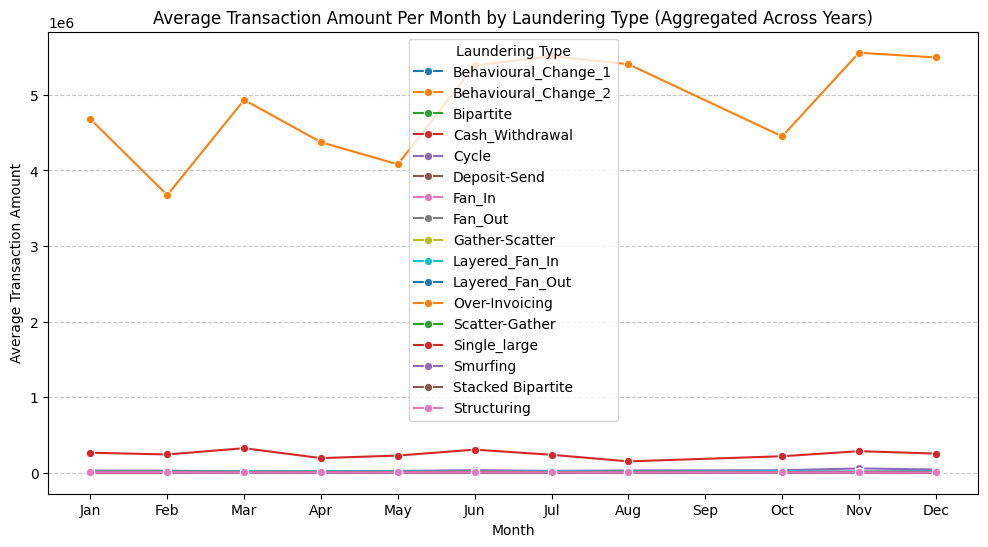

In [27]:
# Compute the average transaction amount per month for each laundering type
monthly_avg_laundering = df_laundering.groupby(['Month', 'Laundering_type'])['Amount'].mean().unstack()

# Plot the monthly average transaction amounts per laundering type
plt.figure(figsize=(12, 6))

# Plot each laundering type separately
for laundering_type in monthly_avg_laundering.columns:
    sns.lineplot(x=monthly_avg_laundering.index, y=monthly_avg_laundering[laundering_type], marker='o', label=laundering_type)

# Labels and title
plt.title('Average Transaction Amount Per Month by Laundering Type (Aggregated Across Years)')
plt.xlabel('Month')
plt.ylabel('Average Transaction Amount')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Laundering Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

#### The "Over-Invoicing" laundering type shows significantly higher average transaction amounts compared to other methods, while most other laundering types remain relatively low and stable throughout the year
---

# Top sender and receiver bank locations

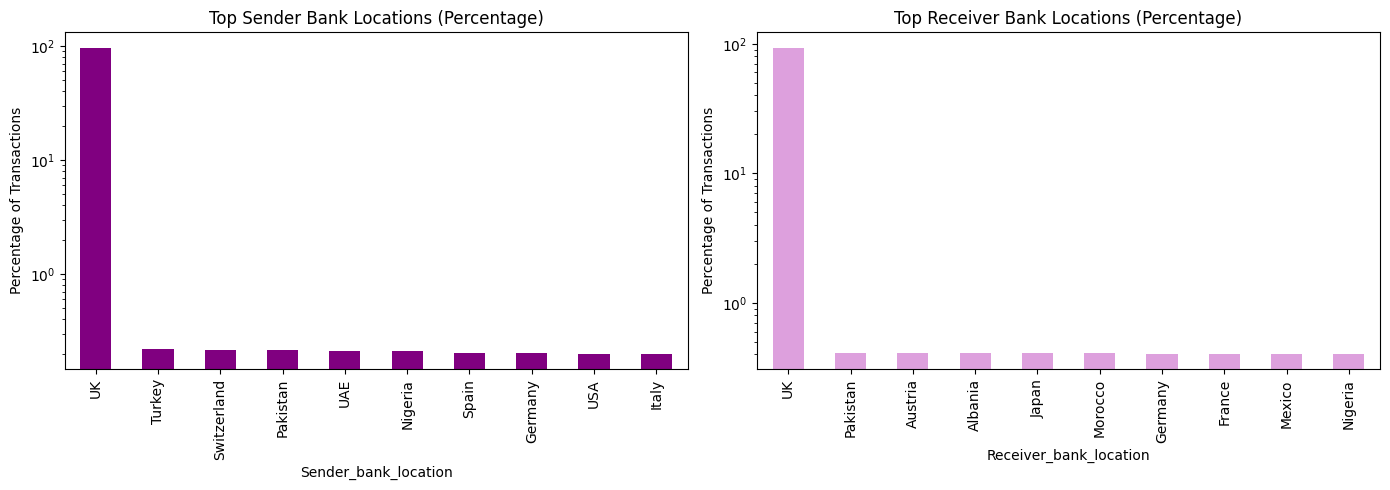

In [28]:
# Normalize by percentage
sender_counts = df['Sender_bank_location'].value_counts(normalize=True) * 100
receiver_counts = df['Receiver_bank_location'].value_counts(normalize=True) * 100

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sender Locations
sender_counts[:10].plot(kind='bar', ax=axes[0], color='purple')
axes[0].set_title("Top Sender Bank Locations (Percentage)")
axes[0].set_ylabel("Percentage of Transactions")
axes[0].set_yscale("log")  # Log scale for visibility

# Receiver Locations
receiver_counts[:10].plot(kind='bar', ax=axes[1], color='plum')
axes[1].set_title("Top Receiver Bank Locations (Percentage)")
axes[1].set_ylabel("Percentage of Transactions")
axes[1].set_yscale("log")  # Log scale for visibility

plt.tight_layout()
plt.show()

# Top money laundering country

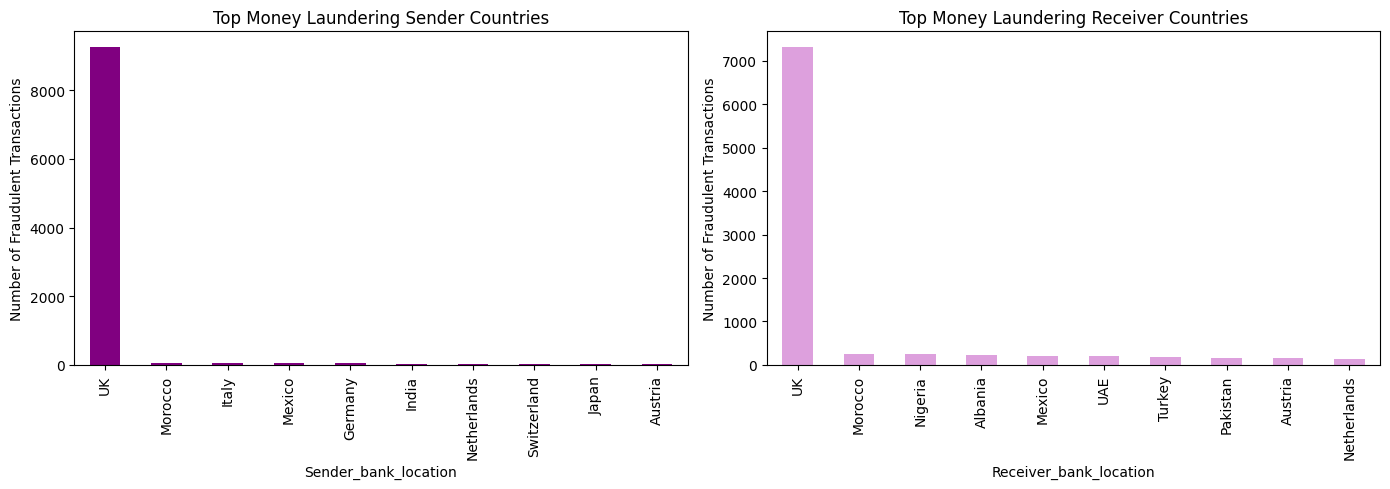

In [29]:
# Count money laundering transactions per country
laundering_senders = df_Laundering['Sender_bank_location'].value_counts()
laundering_receivers = df_Laundering['Receiver_bank_location'].value_counts()

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sender Countries in Money Laundering
laundering_senders[:10].plot(kind='bar', ax=axes[0], color='purple')
axes[0].set_title("Top Money Laundering Sender Countries")
axes[0].set_ylabel("Number of Fraudulent Transactions")

# Receiver Countries in Money Laundering
laundering_receivers[:10].plot(kind='bar', ax=axes[1], color='plum')
axes[1].set_title("Top Money Laundering Receiver Countries")
axes[1].set_ylabel("Number of Fraudulent Transactions")

plt.tight_layout()
plt.show()

#### The UK dominates both sender and receiver bank locations, indicating a central role in transactions, while other countries have significantly lower transaction volumes.
----

# Number of transactions per payment type

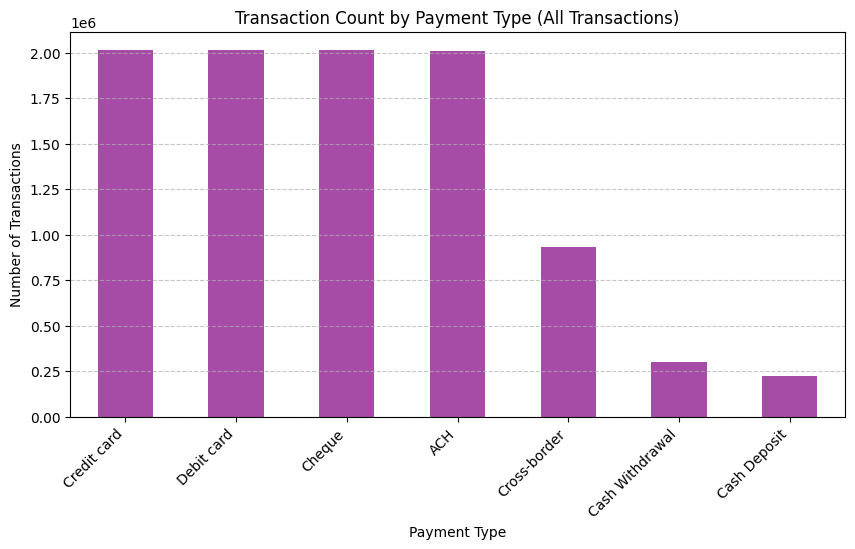

In [30]:
# Number of transaction by payment type
plt.figure(figsize=(10,5))
df['Payment_type'].value_counts().plot(kind='bar', color='purple', alpha=0.7)
plt.title("Transaction Count by Payment Type (All Transactions)")
plt.ylabel("Number of Transactions")
plt.xlabel("Payment Type")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### The first plot shows that credit card, debit card, cheque, and ACH transactions are the most common payment types overall, while cross-border and cash transactions are less frequent.

# Number of fradulent transactions by payment Type

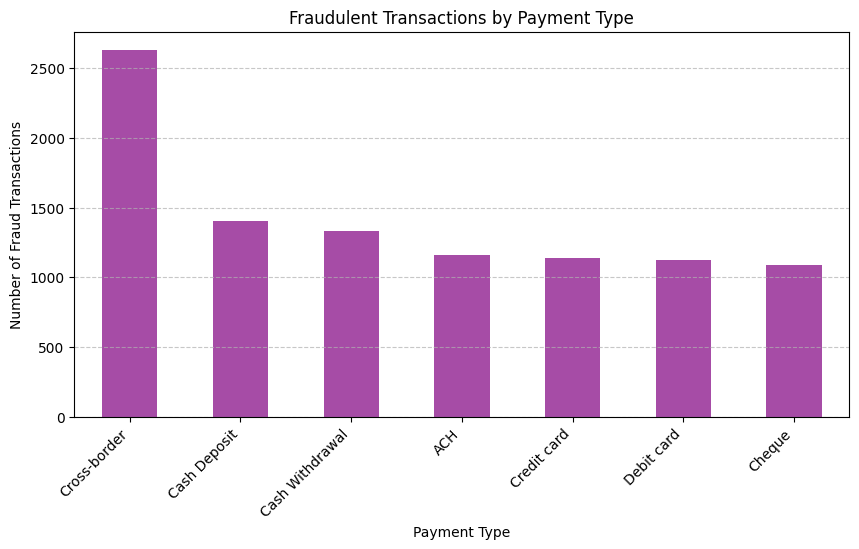

In [31]:
#Number of fradulent transactions by payment Type
plt.figure(figsize=(10,5))
df_Laundering['Payment_type'].value_counts().plot(kind='bar', color='purple', alpha=0.7)
plt.title("Fraudulent Transactions by Payment Type")
plt.ylabel("Number of Fraud Transactions")
plt.xlabel("Payment Type")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### The second plot highlights that fraudulent transactions are more concentrated in cross-border payments, cash deposits, and cash withdrawals, suggesting that these payment methods are more vulnerable to money laundering activities.
----

# Top 10 Money Laundering Techniques

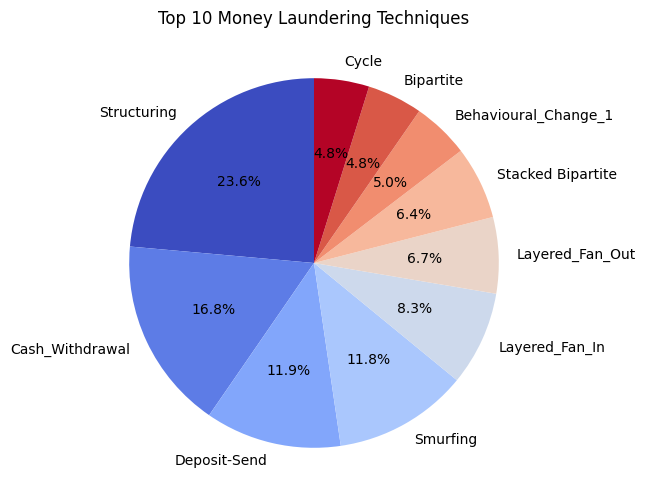

In [32]:
plt.figure(figsize=(10,6))
df_Laundering['Laundering_type'].value_counts().head(10).plot(kind='pie', autopct='%1.1f%%', startangle=90, cmap="coolwarm")
plt.title("Top 10 Money Laundering Techniques")
plt.ylabel("")  # Remove y-axis label for clarity
plt.show()

#### The pie chart highlights that structuring is the most commonly used money laundering technique, followed by cash withdrawals and deposit-send transactions, indicating a preference for breaking large sums into smaller transactions to avoid detection.
----

# Laundering Techniques by Sender Country

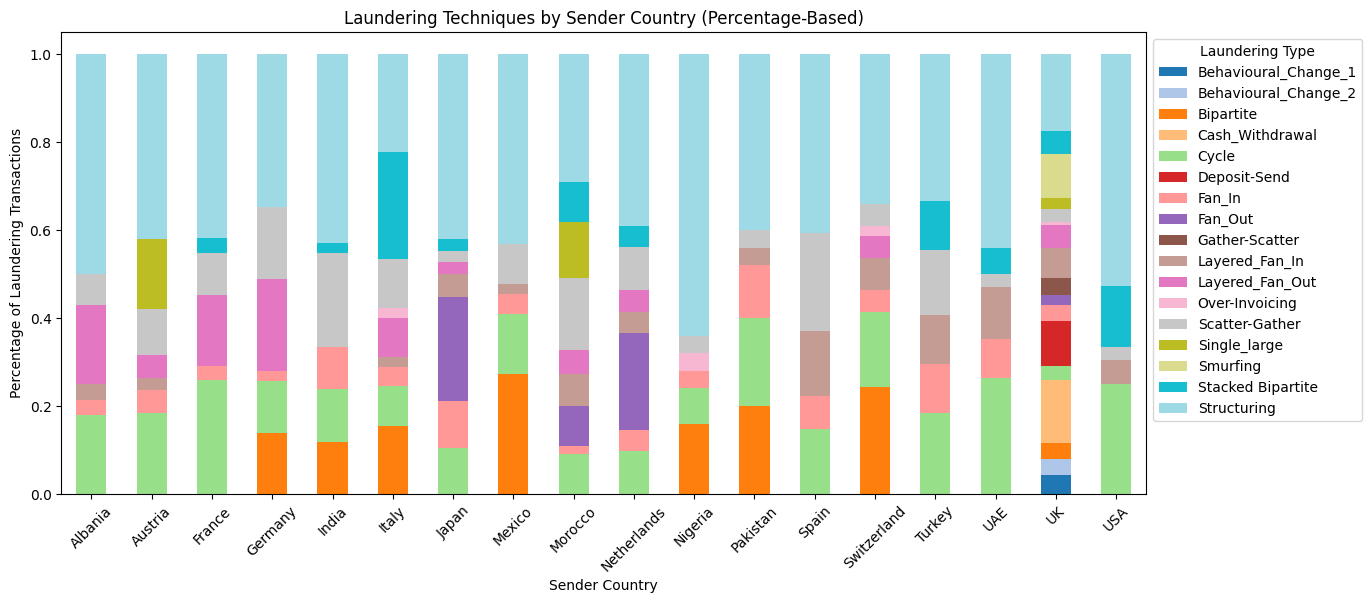

In [33]:
# Group by Sender Country and Laundering Type, then count occurrences
filtered_laundering_sender = df_Laundering.groupby(['Sender_bank_location', 'Laundering_type']).size().unstack(fill_value=0)

# Normalize laundering types within each country
normalized_laundering_sender = filtered_laundering_sender.div(filtered_laundering_sender.sum(axis=1), axis=0)

# Plot stacked bar chart (percentage-based)
normalized_laundering_sender.plot(kind="bar", stacked=True, figsize=(14,6), colormap="tab20")
plt.title("Laundering Techniques by Sender Country (Percentage-Based)")
plt.xlabel("Sender Country")
plt.ylabel("Percentage of Laundering Transactions")
plt.xticks(rotation=45)
plt.legend(title="Laundering Type", bbox_to_anchor=(1, 1))
plt.show()


#### The stacked bar chart shows that structuring is the most dominant laundering technique across most sender countries, while other methods like cash withdrawal, fan-in, and smurfing vary in distribution, suggesting regional laundering strategy preferences.
----


# Laundering Techniques by Receiver Country

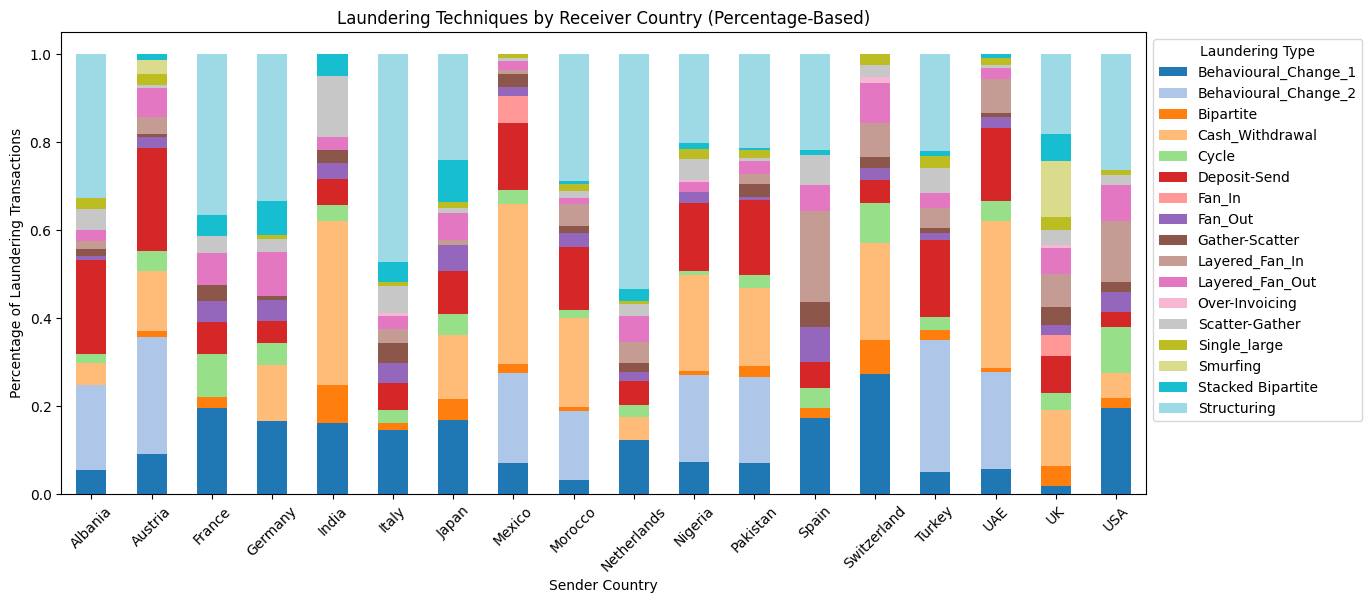

In [34]:
# Group by Sender Country and Laundering Type, then count occurrences
filtered_laundering_sender = df_Laundering.groupby(['Receiver_bank_location', 'Laundering_type']).size().unstack(fill_value=0)

# Normalize laundering types within each country
normalized_laundering_sender = filtered_laundering_sender.div(filtered_laundering_sender.sum(axis=1), axis=0)

# Plot stacked bar chart (percentage-based)
normalized_laundering_sender.plot(kind="bar", stacked=True, figsize=(14,6), colormap="tab20")
plt.title("Laundering Techniques by Receiver Country (Percentage-Based)")
plt.xlabel("Sender Country")
plt.ylabel("Percentage of Laundering Transactions")
plt.xticks(rotation=45)
plt.legend(title="Laundering Type", bbox_to_anchor=(1, 1))
plt.show()

#### The distribution of laundering techniques varies significantly by receiver country, with structuring being the most common method, while techniques like deposit-send, fan-in, and layering show distinct patterns across different regions.
------

#### Dropping `Laundering_type` Column

We drop the `Laundering_type` column because:

It is **highly correlated** with `Is_laundering` and could introduce **data leakage**.  
Our main goal is **binary classification** (laundering vs. non-laundering), so this column is redundant.  
Keeping it might make the model overly reliant on this feature instead of learning real transaction patterns.  

If needed for **multi-class classification (predicting laundering types)**, we could encode it later.  


In [35]:
df.drop(columns=['Laundering_type'], inplace=True)

----

# 4. Feature Engineering

### ✅ Creating Non-Leaking Features

### Binary Feature: Sender & Receiver Location Match
### - Helps detect transactions that stay within the same region.
### - 1 = Same location, 0 = Different location.


In [36]:
df['Sender_Receiver_Same_Location'] = (df['Sender_bank_location'] == df['Receiver_bank_location']).astype(int)


###  Binary Feature: Sender & Receiver Currency Match
### - Identifies currency conversion transactions, which may be more suspicious.
### - 1 = Same currency, 0 = Different currency.


In [37]:
df['Sender_Receiver_Same_Currency'] = (df['Payment_currency'] == df['Received_currency']).astype(int)


In [38]:
# Display results
df[['Sender_bank_location', 'Receiver_bank_location', 'Sender_Receiver_Same_Location',
    'Payment_currency', 'Received_currency', 'Sender_Receiver_Same_Currency']].head()

,Sender_bank_location,Receiver_bank_location,Sender_Receiver_Same_Location,Payment_currency,Received_currency,Sender_Receiver_Same_Currency
0,UK,UK,1,UK pounds,UK pounds,1
1,UK,UAE,0,UK pounds,Dirham,0
2,UK,UK,1,UK pounds,UK pounds,1
3,UK,UK,1,UK pounds,UK pounds,1
4,UK,UK,1,UK pounds,UK pounds,1


Part of a Business Hours Window?

In [39]:
df['Is_Business_Hours'] = df['Hour'].between(9, 17).astype(int)

Morning vs. Evening Transactions

In [40]:
df['Is_Morning'] = (df['Hour'] < 12).astype(int)

#### Label Encoding for Payment and Received Currency

Since `Payment_currency` and `Received_currency` contain multiple unique values, we use **Label Encoding** instead of One-Hot Encoding to avoid creating too many new columns.

#### **Why Label Encoding?**
- One-Hot Encoding would generate too many features, making the dataset unnecessarily large.
- Label Encoding assigns a **unique integer** to each currency while preserving its identity.

#### **What We Did?**
1. **Fitted a `LabelEncoder`** on both columns to transform categorical values into numbers.
2. **Stored the original-to-encoded mappings** for documentation and interpretability.
3. **Printed the mapping** so we can reference what each encoded number represents.

Below is the mapping of currencies to their assigned numbers:


In [41]:
# Initialize LabelEncoders
label_encoder_payment = LabelEncoder()
label_encoder_received = LabelEncoder()

# Fit label encoders
df['Payment_currency'] = label_encoder_payment.fit_transform(df['Payment_currency'])
df['Received_currency'] = label_encoder_received.fit_transform(df['Received_currency'])

# Create a mapping dictionary for documentation
payment_currency_mapping = dict(zip(label_encoder_payment.classes_, label_encoder_payment.transform(label_encoder_payment.classes_)))
received_currency_mapping = dict(zip(label_encoder_received.classes_, label_encoder_received.transform(label_encoder_received.classes_)))

# Print the mapping for markdown documentation
print("### Payment Currency Encoding:")
for key, value in payment_currency_mapping.items():
    print(f"{key} → {value}")

print("\n### Received Currency Encoding:")
for key, value in received_currency_mapping.items():
    print(f"{key} → {value}")


### Payment Currency Encoding:
Albanian lek → 0
Dirham → 1
Euro → 2
Indian rupee → 3
Mexican Peso → 4
Moroccan dirham → 5
Naira → 6
Pakistani rupee → 7
Swiss franc → 8
Turkish lira → 9
UK pounds → 10
US dollar → 11
Yen → 12

### Received Currency Encoding:
Albanian lek → 0
Dirham → 1
Euro → 2
Indian rupee → 3
Mexican Peso → 4
Moroccan dirham → 5
Naira → 6
Pakistani rupee → 7
Swiss franc → 8
Turkish lira → 9
UK pounds → 10
US dollar → 11
Yen → 12


----

#### One-Hot Encoding for Categorical Features

To convert categorical values into numerical format, we applied **One-Hot Encoding** to the following columns:
- `Payment_type`
- `Sender_bank_location`
- `Receiver_bank_location`

#### Why One-Hot Encoding?
These features have a **limited number of categories**, making One-Hot Encoding an effective choice.  
It ensures the model does not assume an **ordinal relationship** between categories.  

We used `drop_first=True` to prevent multicollinearity by removing one redundant category per feature.  


In [42]:
# Apply One-Hot Encoding
df = pd.get_dummies(df, columns=['Payment_type', 'Sender_bank_location', 'Receiver_bank_location'], drop_first=True)

# Display updated column names after encoding
print("Updated Columns After One-Hot Encoding:")
print(df.columns)

Updated Columns After One-Hot Encoding:
Index(['Time', 'Date', 'Sender_account', 'Receiver_account', 'Amount',
       'Payment_currency', 'Received_currency', 'Is_laundering', 'Datetime',
       'Hour', 'DayOfWeek', 'Month', 'DayOfMonth', 'IsWeekend',
       'Sender_Receiver_Same_Location', 'Sender_Receiver_Same_Currency',
       'Is_Business_Hours', 'Is_Morning', 'Payment_type_Cash Deposit',
       'Payment_type_Cash Withdrawal', 'Payment_type_Cheque',
       'Payment_type_Credit card', 'Payment_type_Cross-border',
       'Payment_type_Debit card', 'Sender_bank_location_Austria',
       'Sender_bank_location_France', 'Sender_bank_location_Germany',
       'Sender_bank_location_India', 'Sender_bank_location_Italy',
       'Sender_bank_location_Japan', 'Sender_bank_location_Mexico',
       'Sender_bank_location_Morocco', 'Sender_bank_location_Netherlands',
       'Sender_bank_location_Nigeria', 'Sender_bank_location_Pakistan',
       'Sender_bank_location_Spain', 'Sender_bank_location_S

### Splitting the Data (Train, Validation, Test)
We divide the dataset into:
- **70% Training Data** – Used for model learning.
- **15% Validation Data** – Used for hyperparameter tuning.
- **15% Test Data** – Used for final model evaluation.


In [43]:
# Define target variable
y = df['Is_laundering']
X = df.drop(columns=['Is_laundering'])  # Keep sender/receiver for now

# Split into Train (70%), Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

# Split Temp into Validation (15%) and Test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

# Print dataset shapes
print(f"Training Set: {X_train.shape}, Validation Set: {X_val.shape}, Test Set: {X_test.shape}")


Training Set: (6653396, 57), Validation Set: (1425728, 57), Test Set: (1425728, 57)


#### Creating Historical Features (On Training Data Only)
To prevent data leakage, we **only create history-based features on the training set**, such as:
- `Sender_Total_Transactions`: Total transactions by sender.
- `Sender_Avg_Amount`: Average transaction amount.
- `Sender_Std_Amount`: Standard deviation of transaction amounts.
- `Time_Since_Last_Transaction`: Time difference (minutes) between consecutive transactions.
- `High_Amount_Flag`: Flags unusually large transactions.


In [44]:
# Total transactions per sender
X_train['Sender_Total_Transactions'] = X_train.groupby('Sender_account')['Amount'].transform('count')

# Average transaction amount per sender
X_train['Sender_Avg_Amount'] = X_train.groupby('Sender_account')['Amount'].transform('mean')

# Standard deviation of transaction amounts per sender
X_train['Sender_Std_Amount'] = X_train.groupby('Sender_account')['Amount'].transform('std').fillna(0)

# Time since last transaction (minutes)
X_train = X_train.sort_values(['Sender_account', 'Datetime'])
X_train['Time_Since_Last_Transaction'] = X_train.groupby('Sender_account')['Datetime'].diff().dt.total_seconds() / 60
X_train['Time_Since_Last_Transaction'] = X_train['Time_Since_Last_Transaction'].fillna(X_train['Time_Since_Last_Transaction'].median())

# Flag high-value transactions
X_train['High_Amount_Flag'] = (X_train['Amount'] > (X_train['Sender_Avg_Amount'] + 2 * X_train['Sender_Std_Amount'])).astype(int)


 #### Applying Features to Validation & Test Sets
After computing sender-based features on training data, we **map the same transformations** to validation and test sets using training statistics.


In [45]:
# Apply sender-based statistics to validation and test sets using training values
for df in [X_val, X_test]:
    df['Sender_Total_Transactions'] = df['Sender_account'].map(X_train.groupby('Sender_account')['Sender_Total_Transactions'].mean())
    df['Sender_Avg_Amount'] = df['Sender_account'].map(X_train.groupby('Sender_account')['Sender_Avg_Amount'].mean())
    df['Sender_Std_Amount'] = df['Sender_account'].map(X_train.groupby('Sender_account')['Sender_Std_Amount'].mean()).fillna(0)
    df['Time_Since_Last_Transaction'] = df['Sender_account'].map(X_train.groupby('Sender_account')['Time_Since_Last_Transaction'].median())
    df['High_Amount_Flag'] = (df['Amount'] > (df['Sender_Avg_Amount'] + 2 * df['Sender_Std_Amount'])).astype(int)


#### Dropping `Sender_account` and `Receiver_account`
Since the historical features are created, we **remove the sender and receiver account columns** to avoid data leakage and redundancy.

In [46]:
# Drop sender and receiver account columns after creating relevant features
X_train.drop(columns=['Sender_account', 'Receiver_account'], inplace=True)
X_val.drop(columns=['Sender_account', 'Receiver_account'], inplace=True)
X_test.drop(columns=['Sender_account', 'Receiver_account'], inplace=True)

# Verify dataset shape after dropping unnecessary columns
print(f"Training Set: {X_train.shape}, Validation Set: {X_val.shape}, Test Set: {X_test.shape}")


Training Set: (6653396, 60), Validation Set: (1425728, 60), Test Set: (1425728, 60)


#### Log-Transformed Amount (`Log_Amount`)

To reduce skewness and improve model performance, we apply log transformation to the `Amount` column:

1. **Log Transformation:**  
   - `Log_Amount = log(1 + Amount)`  
   - Stabilizes extreme transaction values.  

2. **Standardization:**  
   - The log-transformed values are standardized using `StandardScaler()`.  
   - Only the training set is used to fit the scaler, and the same scaler is applied to validation & test.  

This ensures all datasets are processed consistently while avoiding data leakage!


In [52]:
# 1) Log-transform the amount column in the training set
X_train['Log_Amount'] = np.log1p(X_train['Amount'])

# 2) Standardize the log-transformed amount for stability
scaler = StandardScaler()
X_train['Log_Amount'] = scaler.fit_transform(X_train[['Log_Amount']])

# 3) Apply the SAME log transformation to validation & test sets
X_val['Log_Amount'] = np.log1p(X_val['Amount'])
X_test['Log_Amount'] = np.log1p(X_test['Amount'])

# 4) Standardize using the SAME scaler from training
X_val['Log_Amount'] = scaler.transform(X_val[['Log_Amount']])
X_test['Log_Amount'] = scaler.transform(X_test[['Log_Amount']])

# Verify the transformation
print("Log_Amount feature applied correctly across all sets!")


Log_Amount feature applied correctly across all sets!


In [54]:
# Display first few rows to check feature values
X_train.head()

,Time,Date,Amount,Payment_currency,Received_currency,Datetime,Hour,DayOfWeek,Month,DayOfMonth,...,Receiver_bank_location_Turkey,Receiver_bank_location_UAE,Receiver_bank_location_UK,Receiver_bank_location_USA,Sender_Total_Transactions,Sender_Avg_Amount,Sender_Std_Amount,Time_Since_Last_Transaction,High_Amount_Flag,Log_Amount
8572082,09:51:28,2023-07-22,3319.06,10,2,2023-07-22 09:51:28,9,5,7,22,...,False,False,False,False,1,3319.0600,0.000000,254.850000,0,-0.171457
4191567,23:31:38,2023-02-24,3878.00,10,10,2023-02-24 23:31:38,23,4,2,24,...,False,False,True,False,4,5235.0775,1454.212911,254.850000,0,-0.060505
5018226,20:51:59,2023-03-24,4109.92,10,10,2023-03-24 20:51:59,20,4,3,24,...,False,False,True,False,4,5235.0775,1454.212911,40160.350000,0,-0.019097
6835459,23:02:45,2023-05-24,6755.32,10,10,2023-05-24 23:02:45,23,2,5,24,...,False,False,True,False,4,5235.0775,1454.212911,87970.766667,0,0.335185
7755804,19:19:18,2023-06-24,6197.07,10,10,2023-06-24 19:19:18,19,5,6,24,...,False,False,True,False,4,5235.0775,1454.212911,44416.550000,0,0.273688


In [55]:
# Show all column names in the training dataset
print("Current columns in X_train:")
print(X_train.columns)

Current columns in X_train:
Index(['Time', 'Date', 'Amount', 'Payment_currency', 'Received_currency',
       'Datetime', 'Hour', 'DayOfWeek', 'Month', 'DayOfMonth', 'IsWeekend',
       'Sender_Receiver_Same_Location', 'Sender_Receiver_Same_Currency',
       'Is_Business_Hours', 'Is_Morning', 'Payment_type_Cash Deposit',
       'Payment_type_Cash Withdrawal', 'Payment_type_Cheque',
       'Payment_type_Credit card', 'Payment_type_Cross-border',
       'Payment_type_Debit card', 'Sender_bank_location_Austria',
       'Sender_bank_location_France', 'Sender_bank_location_Germany',
       'Sender_bank_location_India', 'Sender_bank_location_Italy',
       'Sender_bank_location_Japan', 'Sender_bank_location_Mexico',
       'Sender_bank_location_Morocco', 'Sender_bank_location_Netherlands',
       'Sender_bank_location_Nigeria', 'Sender_bank_location_Pakistan',
       'Sender_bank_location_Spain', 'Sender_bank_location_Switzerland',
       'Sender_bank_location_Turkey', 'Sender_bank_location_U

#### Dropping Unnecessary Columns Before Model Training

Before training our models, we remove unnecessary columns to ensure clean and optimized input features:

**Dropped Columns**  
- `Time`, `Date`, `Datetime` → Already extracted time-based features.  
- `Amount` → Replaced by `Log_Amount` (log-transformed version).  
- `Payment_currency`, `Received_currency` → Already encoded or transformed.  

This ensures our model is trained on the most relevant features without redundant or unnecessary data.


In [56]:
# List of columns to drop before training the models
drop_columns = [
    'Time', 'Date', 'Datetime', 'Amount', 'Payment_currency', 'Received_currency'
]

# Drop columns from training, validation, and test sets
X_train = X_train.drop(columns=drop_columns)
X_val = X_val.drop(columns=drop_columns)
X_test = X_test.drop(columns=drop_columns)

# Verify the remaining feature set
print("Final feature set before model training:")
print(X_train.columns)


Final feature set before model training:
Index(['Hour', 'DayOfWeek', 'Month', 'DayOfMonth', 'IsWeekend',
       'Sender_Receiver_Same_Location', 'Sender_Receiver_Same_Currency',
       'Is_Business_Hours', 'Is_Morning', 'Payment_type_Cash Deposit',
       'Payment_type_Cash Withdrawal', 'Payment_type_Cheque',
       'Payment_type_Credit card', 'Payment_type_Cross-border',
       'Payment_type_Debit card', 'Sender_bank_location_Austria',
       'Sender_bank_location_France', 'Sender_bank_location_Germany',
       'Sender_bank_location_India', 'Sender_bank_location_Italy',
       'Sender_bank_location_Japan', 'Sender_bank_location_Mexico',
       'Sender_bank_location_Morocco', 'Sender_bank_location_Netherlands',
       'Sender_bank_location_Nigeria', 'Sender_bank_location_Pakistan',
       'Sender_bank_location_Spain', 'Sender_bank_location_Switzerland',
       'Sender_bank_location_Turkey', 'Sender_bank_location_UAE',
       'Sender_bank_location_UK', 'Sender_bank_location_USA',
      